Before starting implementation, we need to think about the problem.
1. Explore the website and different sections
	- Different charts including price data for Estonia, Latvia, Lithuania

2. Read the task
	- Identifying the problem - what does balancing energy mean?
	- Answer: Balancing energy is used to prevent energy imbalances in electricity grids. When demand drops, balancing energy is decreased to compensate and balance supply-demand. When demand rises, balancing energy is increased to compensate and balance supply-demand. This is done at short notice and in real time. Balancing energy prices reflect the cost of correcting supply and demand.

3. Model
  - We will make a model that predicts 24 hours at once. It will be trained on data until 2024-09-01. We will use September 01-30 2024 as test data. In this notebook, we will demonstrate predictions the following way: Models are trained once, and after that for each day in the test data, we will make predictions about each hour for the next 24 hours using already predicted values from the previous hours. At the start of the next day, update our predicted data with the ground truth data, such that it can be used to predict the next 24 hours and repeat. This is meant to simulate the incoming data each day. In production, it is possible to automate this, which will be explained in the usage in production section.
  - This notebook will implement 3 models - Linear Regression, XGBoost and LSTM.
  - Data used for train and test is from 01-01-2020 to 30-09-2024. I chose to get training data from 2020 onward because this is more than enough data. I think even getting from 2022 onward will be enough.

In [1]:
#Start with loading the data using pandas dataframe. Our data is in CSV due to ease of parsing CSV using pandas.
from google.colab import files
import pandas as pd

train_cutoff='2024-08-30 23:00' # we will treat train data to be before this date and test to be after
useScaler = False #normalize features
xgb_grid_search = False #Since grid search CV is very slow, keep this as a global option for easy turn off/on
show_train_metrics = False #Since computing train metrics is slow, keep this as a global option for easy turn off/on


data_orig = files.upload() # or make a get request to BTD api; I have downloaded the data locally since for some reason I couldn't send a get request from colab. I could do it with no problem using Postman.
data = data_orig.copy() #done so i can execute all colab cells without needing to upload file every time - data_orig is in the runtime after first execution, can be commented after that
data_df = pd.read_csv(next(iter(data)), sep=';', decimal=',', quotechar='"')
print(data_df.head())
print(f"Length of data: {len(data_df)}")

Saving 2020-2024.csv to 2020-2024.csv
     datetime_from      datetime_to     area  Upward  Downward
0  2020-01-01 0:00  2020-01-01 1:00  Estonia   35.00     30.83
1  2020-01-01 1:00  2020-01-01 2:00  Estonia   61.00     28.78
2  2020-01-01 2:00  2020-01-01 3:00  Estonia   28.45     28.45
3  2020-01-01 3:00  2020-01-01 4:00  Estonia   27.90     27.90
4  2020-01-01 4:00  2020-01-01 5:00  Estonia   27.52     27.52
Length of data: 124845


We see hourly timestamps with upward/downward entries for each of estonia, latvia, lithuania. Lets combine upward and downward columns, and leave only Estonia, as specified in the task .

In [2]:
def prepare_data(data_df):
    data_df = data_df.drop("Downward", axis=1)
    data_df = data_df.drop("datetime_to", axis=1) #useless column, it is just datetime_from + 1 hour
    data_df = data_df.rename(columns={'Upward': 'price', "datetime_from":"datetime"})
    data_df = data_df[data_df['area'] == 'Estonia'] #leave only estonia to remove duplicate data
    data_df = data_df.drop("area", axis=1) #remove area since it is only estonia

    data_df['datetime'] = pd.to_datetime(data_df['datetime']) # currently string
    data_df = data_df.set_index('datetime').sort_index() #set index to datetime and sort data

    data_df = data_df[~data_df.index.duplicated(keep='last')] #data has some duplicated datetimes - ['2020-10-25 03:00:00', '2021-10-31 03:00:00', '2022-10-30 03:00:00', '2023-10-29 03:00:00'] - I suppose summer/winter timezone changes in octomber changing the clock back 1 hour
    data_df = data_df.resample('h').ffill() #added missing hours with forward fill, I presume changing the clock forward by 1 hour

    print(data_df.head())
    print(f"Length of data: {len(data_df)}")
    return data_df

data_df = prepare_data(data_df)

                     price
datetime                  
2020-01-01 00:00:00  35.00
2020-01-01 01:00:00  61.00
2020-01-01 02:00:00  28.45
2020-01-01 03:00:00  27.90
2020-01-01 04:00:00  27.52
Length of data: 41616


Now we will make some plots to see if there are any trends in the data.

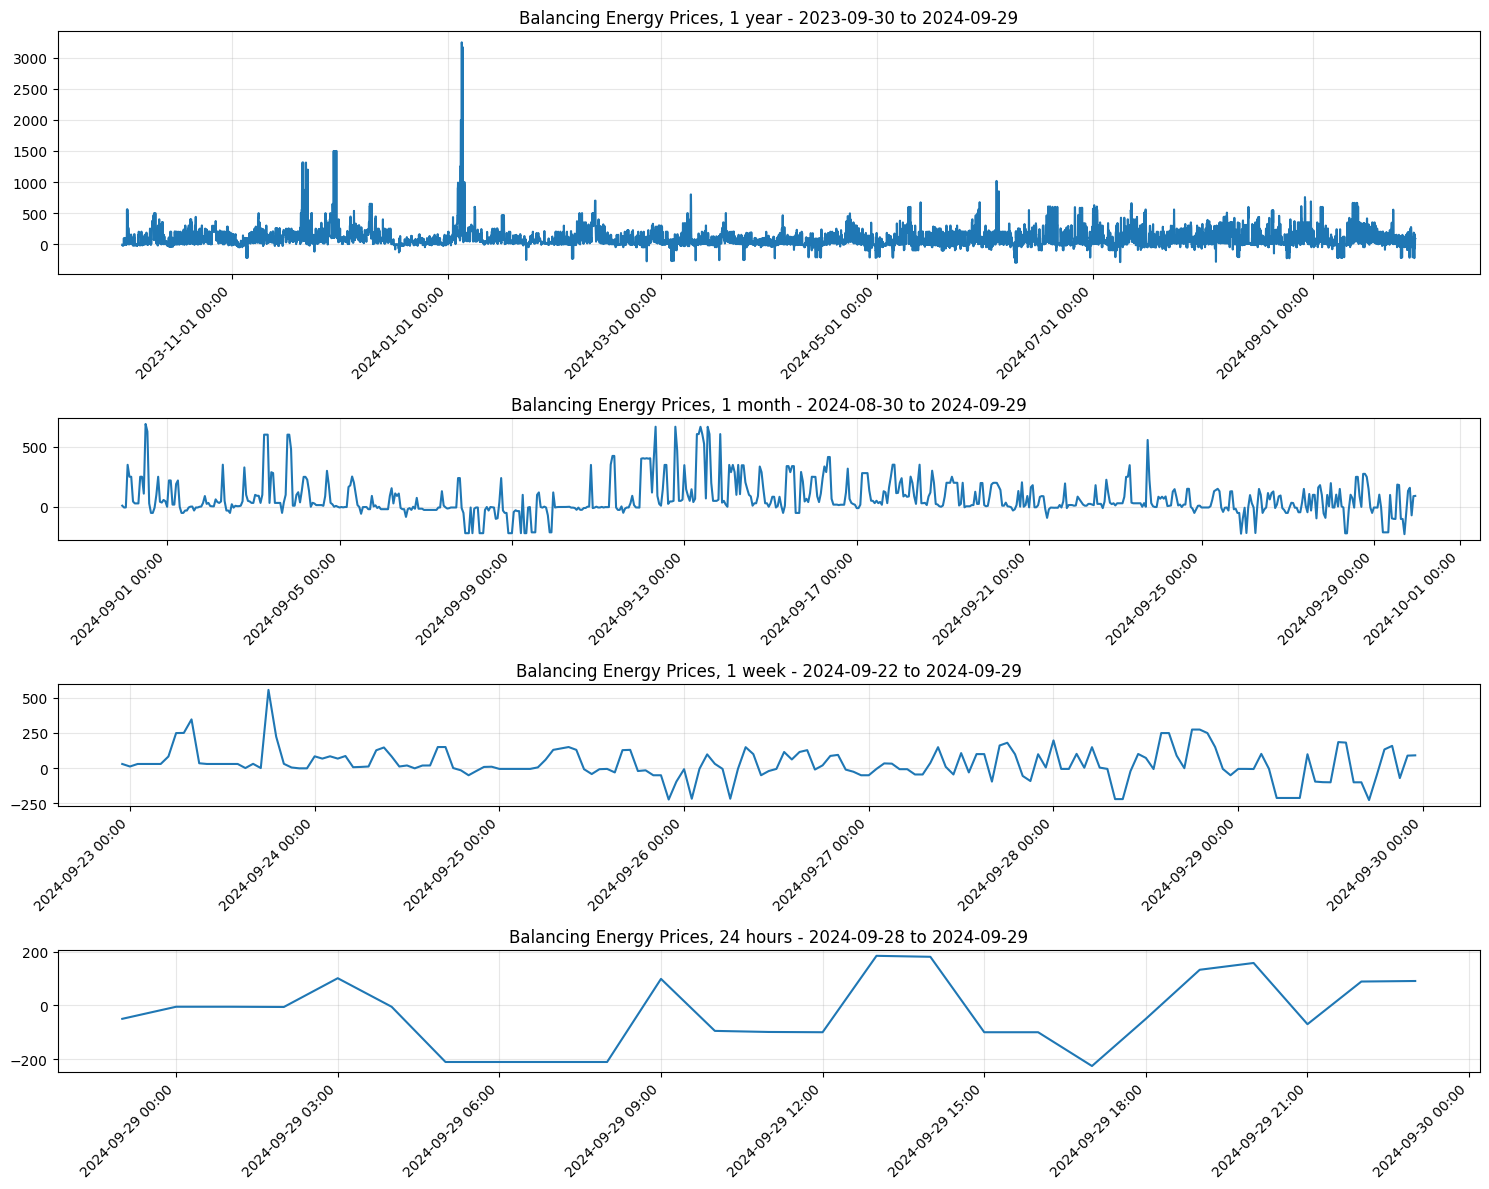

In [3]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# time ranges - we will look at last year, last month, last week, last day
last_from = data_df.index.max()
last_year = last_from - pd.Timedelta(days=365)
last_month = last_from - pd.Timedelta(days=30)
last_week = last_from - pd.Timedelta(days=7)
last_day = last_from - pd.Timedelta(days=1)

#create figure with subplots
fig, axes = plt.subplots(4, 1, figsize=(15, 12), height_ratios=[2, 1, 1, 1])

#year
axes[0].plot(data_df.loc[last_year:last_from].index, data_df.loc[last_year:last_from]['price']) #note index is the datetime column
axes[0].set_title(f'Balancing Energy Prices, 1 year - {last_year.date()} to {last_from.date()}', fontsize=12)
axes[0].grid(True, alpha=0.3)

#month
axes[1].plot(data_df.loc[last_month:last_from].index, data_df.loc[last_month:last_from]['price'])
axes[1].set_title(f'Balancing Energy Prices, 1 month - {last_month.date()} to {last_from.date()}', fontsize=12)
axes[1].grid(True, alpha=0.3)

#week
axes[2].plot(data_df.loc[last_week:last_from].index, data_df.loc[last_week:last_from]['price'])
axes[2].set_title(f'Balancing Energy Prices, 1 week - {last_week.date()} to {last_from.date()}', fontsize=12)
axes[2].grid(True, alpha=0.3)

#day
axes[3].plot(data_df.loc[last_day:last_from].index, data_df.loc[last_day:last_from]['price'])
axes[3].set_title(f'Balancing Energy Prices, 24 hours - {last_day.date()} to {last_from.date()}', fontsize=12)
axes[3].grid(True, alpha=0.3)

#make timestamp more readable
for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

 Some thoughts about the data:
 1. Most of the data seems to be between ~ (-100;500).
 2. We can see that every timescale, the price doesnt seem to be increasing or decreasing with time - It seems trends are not time dependent but date dependent - for example special dates seem to have higher price, for example the spike in new year and the two spikes in december.
 3. It is interesting that price can be negative - balancing energy providers are willing to pay?
 4. We could divide the timestamp into different columns that better separate the information that the timestamp holds and allow our model to see this data more easily, for example day_of_week, is_weekend and so on (Feature engineering). This will allow the model to associate big spikes with concrete features, for example the big spike after new year will be associated with first of january, so it could probably predict a big spike at the next new year.
 5. Feature engineering will be done because timestamp is unique for each observation, and the model could memorize the timestamps which will lead to overfitting, instead of looking at the meaning of the timestamps, whether it is early in the morinng or late at night(hours), summer or winter(months), and so on.

In [4]:
#lets see some statistics about our data to better understand it
import numpy as np

lower, upper = np.percentile(data_df['price'], [5, 95])
print(f"90% of prices are between: {lower:.2f} and {upper:.2f}")

mean = np.mean(data_df['price'])
std = np.std(data_df['price'])
print(f"Mean: {mean:.2f}, Std: {std:.2f}")
print(f"Max: {np.max(data_df['price']):.2f}, Min: {np.min(data_df['price']):.2f}")

90% of prices are between: -5.82 and 422.61
Mean: 117.33, Std: 154.67
Max: 3250.50, Min: -321.00


Now, as our first model we will implement a simple linear regression model and see how it performs.

XGBoost seems like the most reasonable choice for a model for this data. XGBoost models sharp jumps and complex relationships well, which I expect the linear regression model won't be able to do. The feature engineering that we will do that splits the datetime will be helpful for XGBoost.

I will also implement a deep learning neural network model, namely an LSTM to compare the results of XGBoost with the NN. I assume XGBoost will do a good enough job, I also think it will do even better than the LSTM, but I want to compare both models for this task. I should note that a neural network model will require more data than the XGBoost model, since neural networks are typically data hungry, but I think that data from two years in the past will be enough. I won't try to implement Transformer based models because it would require even more data, training will be slower, which I think is not appropriate for real time models like this. I think we can also use a vanilla neural network as well, but we will stick to LSTMs since they model time series better.

In [5]:
from sklearn.preprocessing import StandardScaler

#Lets start with some feature engineering

def add_features(data_df):
    assert(len(data_df) > 72)

    #lag and rolling average/std
    for lag in range(1, 25):
        data_df[f'lag_{lag}'] = data_df['price'].shift(lag)

    data_df['rolling_mean_24'] = data_df['price'].shift(1).rolling(24).mean() #we shift by 1 to exclude current row in the rolling mean to prevent data leakage
    data_df['rolling_mean_72'] = data_df['price'].shift(1).rolling(72).mean() #we shift by 1 to exclude current row in the rolling mean to prevent data leakage

    data_df['price_change_1h'] = data_df['price'].shift(1) - data_df['price'].shift(2) #These column are meant to account for the volatility in the data - The farther from 0, the higher volatility
    data_df['price_change_6h'] = data_df['price'].shift(1) - data_df['price'].shift(7)
    data_df['price_change_24h'] = data_df['price'].shift(1) - data_df['price'].shift(25)

    data_df['rolling_std_6h'] = data_df['price'].shift(1).rolling(6).std() # Standard deviation to account for the volatility as well
    data_df['rolling_std_24h'] = data_df['price'].shift(1).rolling(24).std()

    data_df['rolling_range_6h'] = data_df['price'].shift(1).rolling(6).max() - data_df['price'].shift(1).rolling(6).min()


    #time based features.
    data_df['hour'] = data_df.index.hour
    data_df['day'] = data_df.index.day
    data_df['month'] = data_df.index.month
    data_df['year'] = data_df.index.year

    #drop na's because of shifting
    data_df.dropna(inplace=True)

    return data_df

#separate train test data
def train_test_split(data_df, use_date=True, train_to=train_cutoff, n=0):
    if use_date:
        train = data_df[data_df.index <= train_to]
        test = data_df[data_df.index > train_to]
    else:
        train = data_df.iloc[:n]
        test = data_df.iloc[n:]

    #we want to predict price, so we separate it
    X_train = train.drop(columns=['price'])
    y_train = train['price']

    X_test = test.drop(columns=['price'])
    y_test = test['price']

    first = X_test.index.min() #timestamp of first test entry by datetime
    last = X_test.index.max() #timestamp of last test entry by datetime

    return X_train, y_train, X_test, y_test, first, last

data_df = add_features(data_df)
X_train, y_train, X_test, y_test, first, last = train_test_split(data_df)

print(f"Train length: {len(X_train)}, Test length: {len(X_test)}")

scaler = None
X_train_orig = X_train.copy() #To be used by the LSTM model later, since we wont use standardScaler there
X_test_orig = X_test.copy() #To be used by the LSTM model later, since we wont use standardScaler there
if useScaler:
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

Train length: 40824, Test length: 720


In [6]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) #Getting future warnings, will disable to not bloat document
warnings.simplefilter(action='ignore', category=UserWarning)

from sklearn.metrics import mean_squared_error
from collections import OrderedDict
import pandas as pd

def build_row(history_data, current_time): # Feature row that will be used by model to make prediction
    row = OrderedDict() #Order is needed because when converted to np array, column names are removed and features are recognised by order
    for lag in range(1, 25):
        row[f'lag_{lag}'] = float(history_data.iloc[-lag])

    row['rolling_mean_24'] = float(history_data.iloc[-25:-1].mean())
    row['rolling_mean_72'] = float(history_data.iloc[-73:-1].mean())

    row['price_change_1h'] = float(history_data.iloc[-1] - history_data.iloc[-2])
    row['price_change_6h'] = float(history_data.iloc[-1] - history_data.iloc[-7])
    row['price_change_24h'] = float(history_data.iloc[-1] - history_data.iloc[-25])

    row['rolling_std_6h'] = float(history_data.iloc[-7:-1].std())
    row['rolling_std_24h'] = float(history_data.iloc[-25:-1].std())

    row['rolling_range_6h'] = float(history_data.iloc[-7:-1].max() - history_data.iloc[-7:-1].min())

    row['hour'] = float(current_time.hour)
    row['day'] = float(current_time.day)
    row['month'] = float(current_time.month)
    row['year'] = float(current_time.year)

    row_df = pd.DataFrame([row], index=[current_time]).astype(float)

    if useScaler:
        row_df = scaler.transform(row_df)

    return row_df


def predict(model, y_test, y_train, first, last):
  '''function to make 24 hour predictions over the whole test data, updates history every 24 hours with ground truth; in the context of a single day uses previous predictions to predict next hour'''

  history_data = y_train.copy() #keeps ground truth prices and predictions. At the end of the day, we will change the predicted prices with ground truth prices
  assert(len(history_data) > 72) # rolling_mean_72 requires data 72 hour back

  forecast_results = [] #will keep all predicted results from the whole test dataset

  current_time = first

  #loop over test dataset by hours
  while current_time <= last:
      row = build_row(history_data, current_time)

      pred = model.predict(row)[0] #returns single item collection, so take 0 index - prediction for next hour
      forecast_results.append((current_time, pred))

      new_row = pd.DataFrame({'price': [pred]}, index=[current_time])
      history_data = pd.concat([history_data, new_row]) #keep predictions in history_data for now

      # every 24 hours replace predictions in history_data with ground truth
      if  len(forecast_results) > 0 and len(forecast_results) % 24 == 0:
          last_24_timestamps = [ts for ts, _ in forecast_results[-24:]]
          true_vals = y_test.loc[last_24_timestamps]
          true_df = pd.DataFrame({'price': true_vals})
          history_data[-24:] = true_df

      current_time += pd.Timedelta(hours=1)#increment time with 1 hour


  forecast_df = pd.DataFrame(forecast_results, columns=['datetime', 'predicted_price']).set_index('datetime')

  rmse = np.sqrt(mean_squared_error(y_test, forecast_df['predicted_price']))
  mae = np.mean(np.abs(y_test - forecast_df['predicted_price']))

  return (forecast_df['predicted_price'], rmse, mae)

In [7]:
# We will plot the prediction for 3 different timeframes - whole data(1 month), 1 week, 1 day

# helper to plot actual vs predicted
def plot_range(y_true, y_pred, title, rmse, mae):
    plt.figure(figsize=(14, 5))
    plt.plot(y_true, label='Actual Price', alpha=0.7)
    plt.plot(y_pred, label='Predicted Price', alpha=0.7)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend(['Actual', 'Predicted'])
    plt.text(0.95, 1.0,  f'RMSE: {rmse:.2f}, MAE: {mae:.2f}', transform=ax.transAxes, ha='right', va='top', bbox=dict(facecolor='white', alpha=0.5))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_all(y_test, y_pred, rmse, mae):
  #convert predictions to Series with datetime index so the prediction is correctly tied with datetime in the plot
  y_pred_series = pd.Series(y_pred, index=y_test.index)

  plot_range(y_test, y_pred_series, 'Actual vs Predicted Prices (Full Test Set)', rmse, mae)

  start = y_test.index.min()
  end_week = start + pd.Timedelta(days=7)
  plot_range(y_test.loc[start:end_week], y_pred_series.loc[start:end_week], 'Actual vs Predicted Prices (First Week)', rmse, mae)

  end_day = start + pd.Timedelta(days=1)
  plot_range(y_test.loc[start:end_day], y_pred_series.loc[start:end_day], 'Actual vs Predicted Prices (First Day)', rmse, mae)


In [8]:
def get_train_metrics(model, data_df, lstm=False, scaler=False, y_scaler=False): #Slow function because it does 24 hour predictions for the whole dataset
    X_train, y_train, X_test, y_test, first, last = train_test_split(data_df[data_df.index <= train_cutoff], use_date=False, n=73) #get train data only

    if not lstm:
        y_pred, rmse, mae = predict(model, y_test, y_train, first, last) #predict on train data
    else:
        y_pred, rmse, mae = predict_lstm(model, y_test, y_train, first, last, scaler, y_scaler) #predict on train data

    return rmse, mae


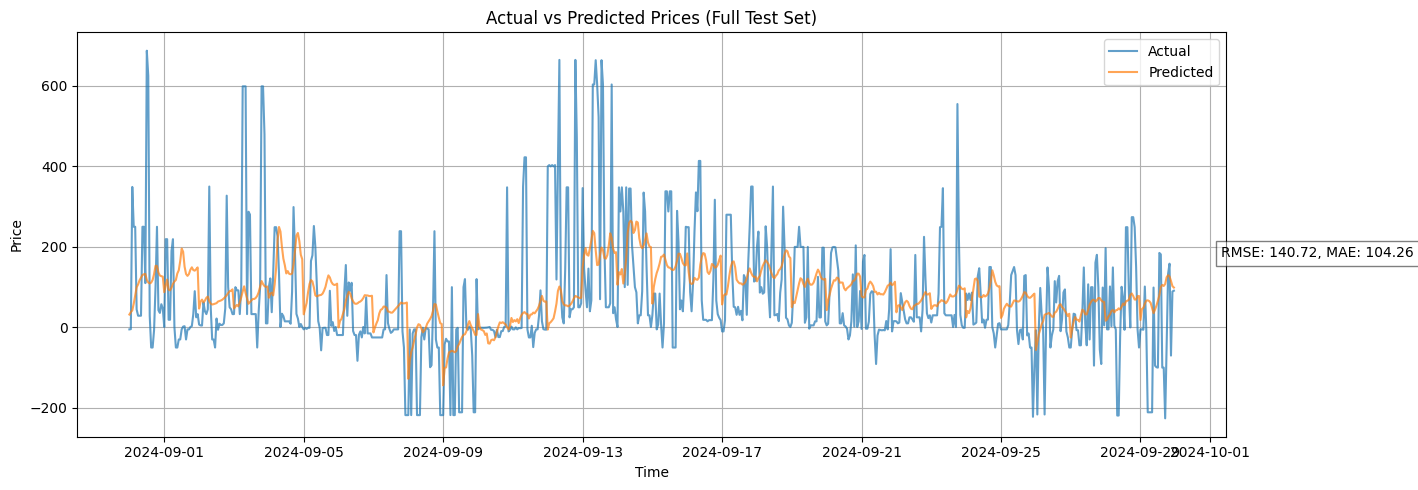

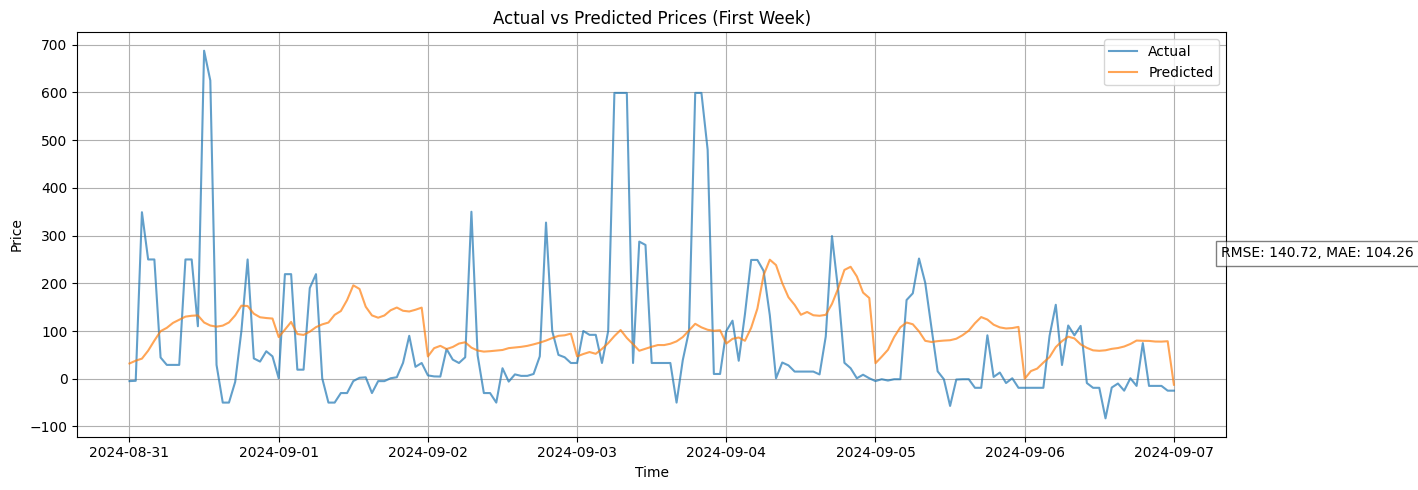

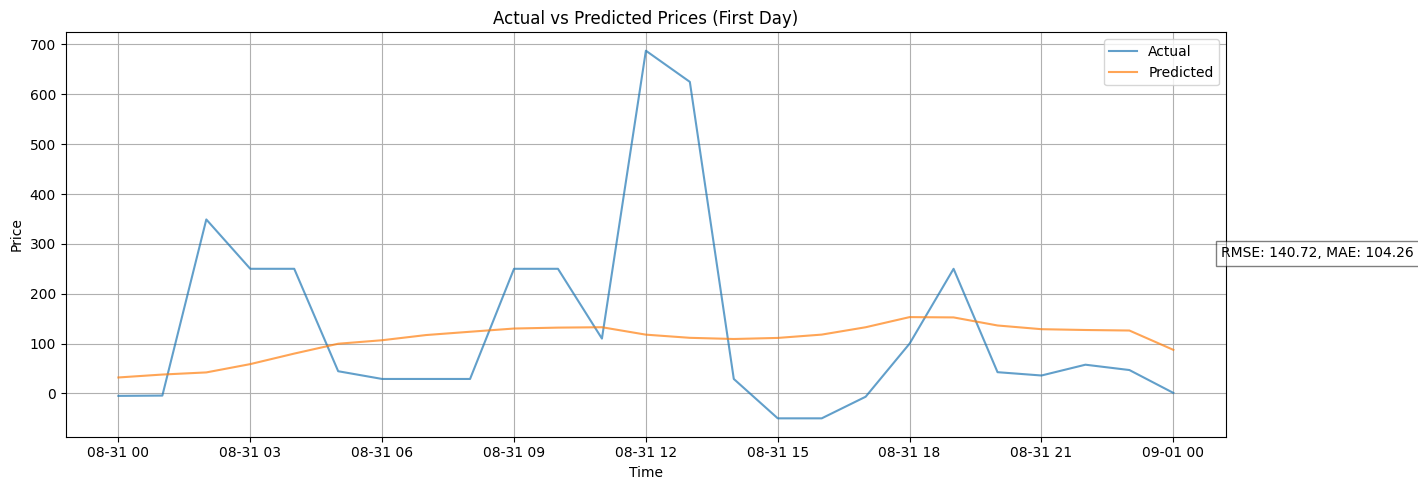

Linear regression test RMSE: 140.72362568031608, Linear Regression test MAE: 104.2572215133475


In [9]:
#Lets see how linear regression performs

from sklearn.linear_model import LinearRegression

LR_model = LinearRegression()
LR_model.fit(X_train, y_train)

linear_regression_y_pred, linear_regression_rmse, linear_regression_mae = predict(LR_model, y_test, y_train, first, last) #returns pandas series and two numbers
plot_all(y_test, linear_regression_y_pred, linear_regression_rmse, linear_regression_mae)

if show_train_metrics:
    #get train metrics - train RMSE and train MAE; Note that it takes time to execute this
    train_rmse, train_mae = get_train_metrics(LR_model, data_df)
    print(f'Linear regression train RMSE: {train_rmse}, Linear regression train MAE: {train_mae}')

print(f'Linear regression test RMSE: {linear_regression_rmse}, Linear Regression test MAE: {linear_regression_mae}')

From the charts it seems like real data is more volatile and the linear regression model doesn't predict these sudden jumps very well. We can see that on the weekly chart, at the start of each day, the predicted price is always lower than the previous day. This is because we update the ground truth prices at the start of each day. I think this makes sense, because the linear regression model on average will predict a little bit higher, because the model is not as volatile as the real data, and the big jumps in the real data are compensated by higher average price the model predicts. Also we can see that training RMSE is lower, so our model slightly overfits. Lets see if the mean of the predictions really is bigger than the mean of y_test.

In [10]:
linear_regression_mean = np.mean(linear_regression_y_pred)
linear_regression_std = np.std(linear_regression_y_pred)
y_test_mean = np.mean(y_test)
y_test_std = np.std(y_test)
print(f"Linear Regression Mean: {linear_regression_mean:.2f}, Linear Regression Std: {linear_regression_std:.2f}")
print(f"Real Mean: {y_test_mean:.2f}, Real Std: {y_test_std:.2f}")

Linear Regression Mean: 84.91, Linear Regression Std: 62.16
Real Mean: 70.65, Real Std: 148.61


It turns out the mean is higher than the real mean and the standard deviation is way smaller, which was expected looking at the graphs.

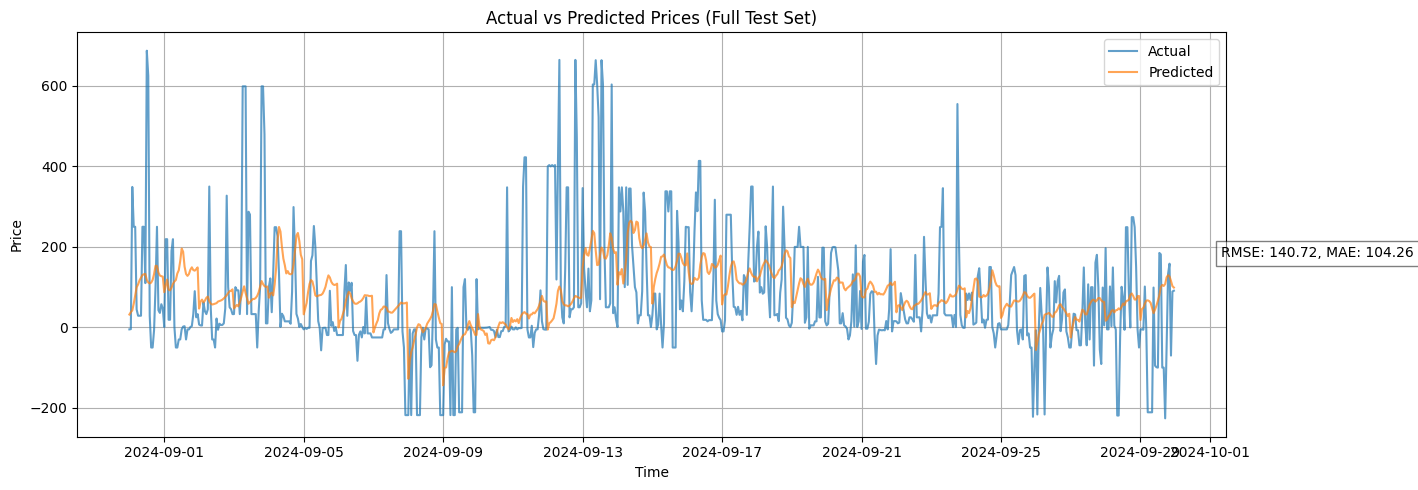

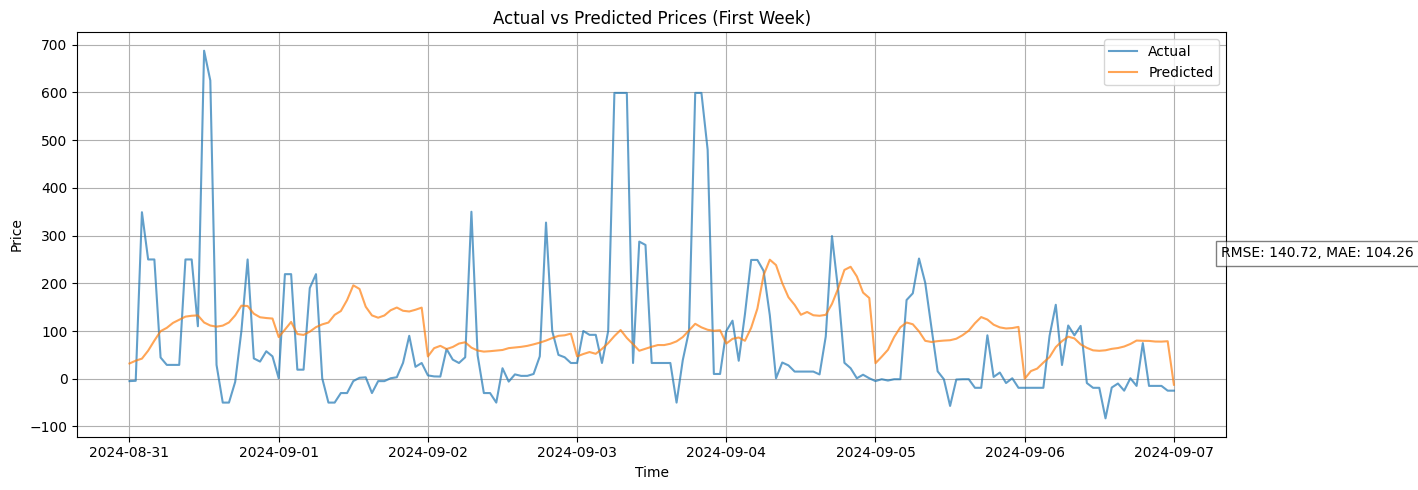

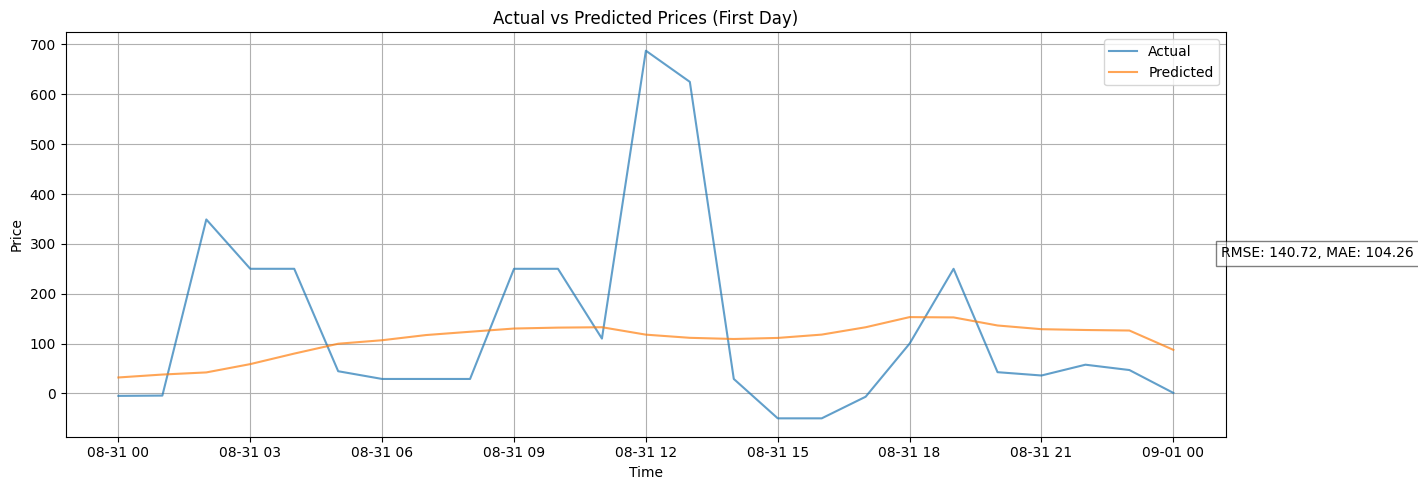

In [11]:
#We can see the model slightly overfits, so we will try ridge, which is basically linear regression with L2 regularization - penalize large coefficients
from sklearn.linear_model import Ridge

ridge_model = Ridge(alpha=3.0)
ridge_model.fit(X_train, y_train)
ridge_y_pred, ridge_rmse, ridge_mae = predict(LR_model, y_test, y_train, first, last) #returns pandas series and two numbers
plot_all(y_test, ridge_y_pred, ridge_rmse, ridge_mae)

I tried different values for the ridge alpha parameter, but all of them resulted in the same RMSE, which is the same for the vanilla linear regression.

Now let's try a different model - XGBoost

In [12]:
#Lets see how XGBoost performs

import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit


if xgb_grid_search:
    # Find the  best hyperparams using cross validation - note that it takes time to execute this because it tries all combinations; for faster CV we can do RandomizedSearchCV
    param_grid = {
        'max_depth': [3, 5],
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [100, 150, 200, 250, 300, 500],
        'objective': ['reg:squarederror', 'reg:absoluteerror'],
        'reg_lambda': [0, 1, 2, 3, 4] #L2 regularization
    }

    grid = GridSearchCV(
        estimator=xgb.XGBRegressor(),
        param_grid=param_grid,
        cv=TimeSeriesSplit(n_splits=3), #Use this instead of normal K fold cv, because we want training data to always occur before test data in time, and normal K-fold CV shuffles data randomly, which is potential data leakage
        scoring='neg_mean_squared_error'
    )

    grid.fit(X_train, y_train)

    print("best parameters for XGB - ", grid.best_params_)

    XGB_model = grid.best_estimator_

else:
    #Executing the above code gives best parameters for XGB -  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 250, 'objective': 'reg:squarederror', 'reg_lambda': 0}
    XGB_model = xgb.XGBRegressor(
        n_estimators=250, #number of trees
        max_depth=3, #max depth of each tree
        learning_rate=0.1, #lr
        objective='reg:squarederror', #tested with both squared error and absoluteerror, but square error works better
        reg_lambda=0
    )

    XGB_model.fit(X_train, y_train)

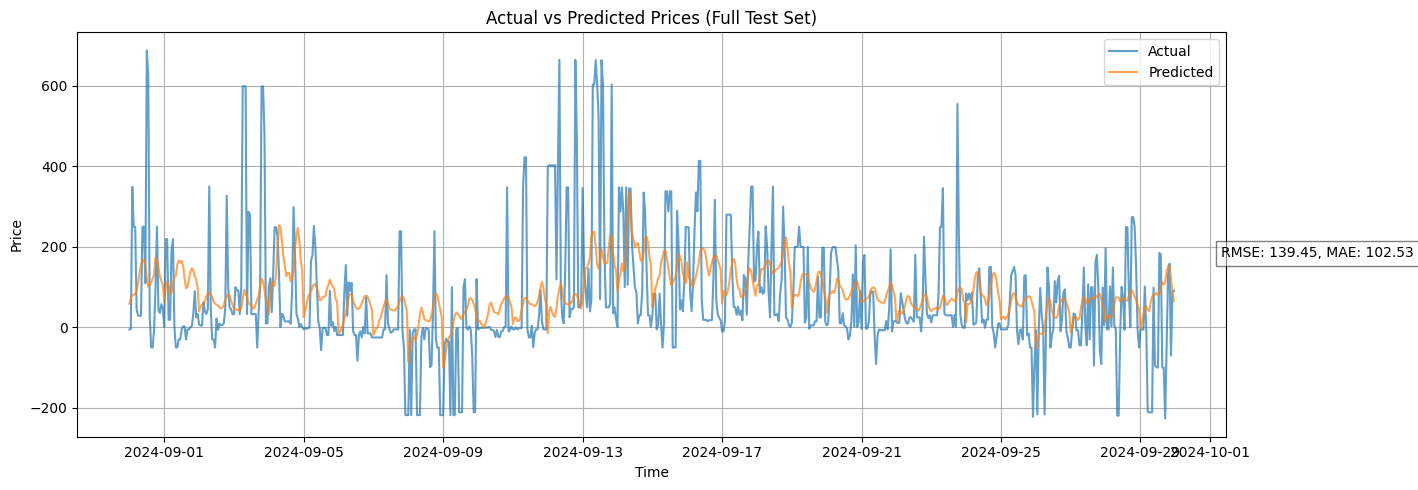

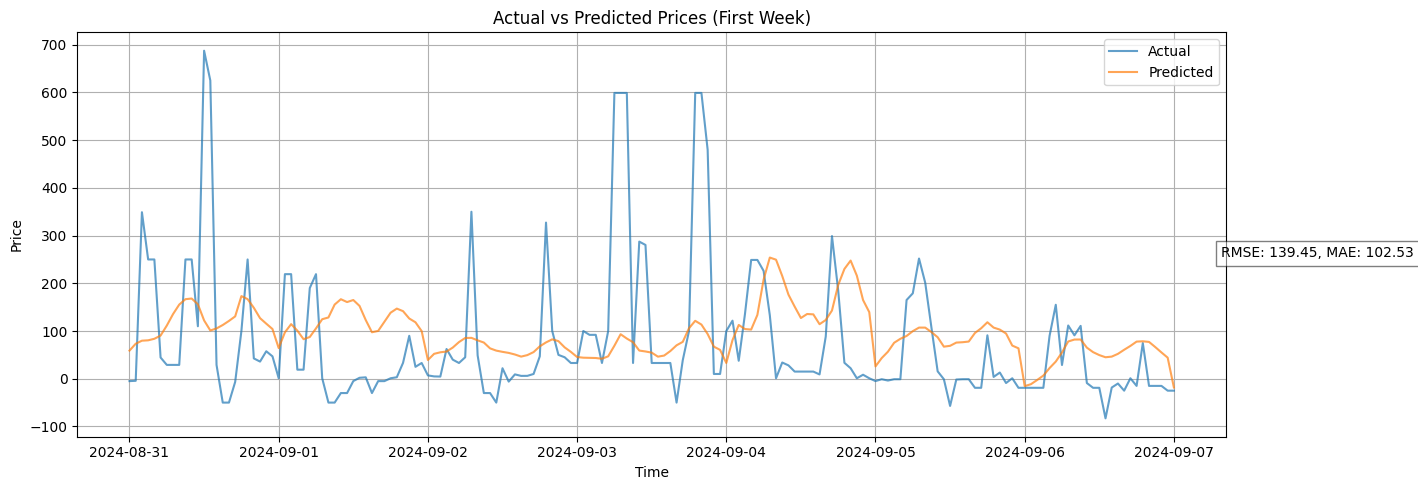

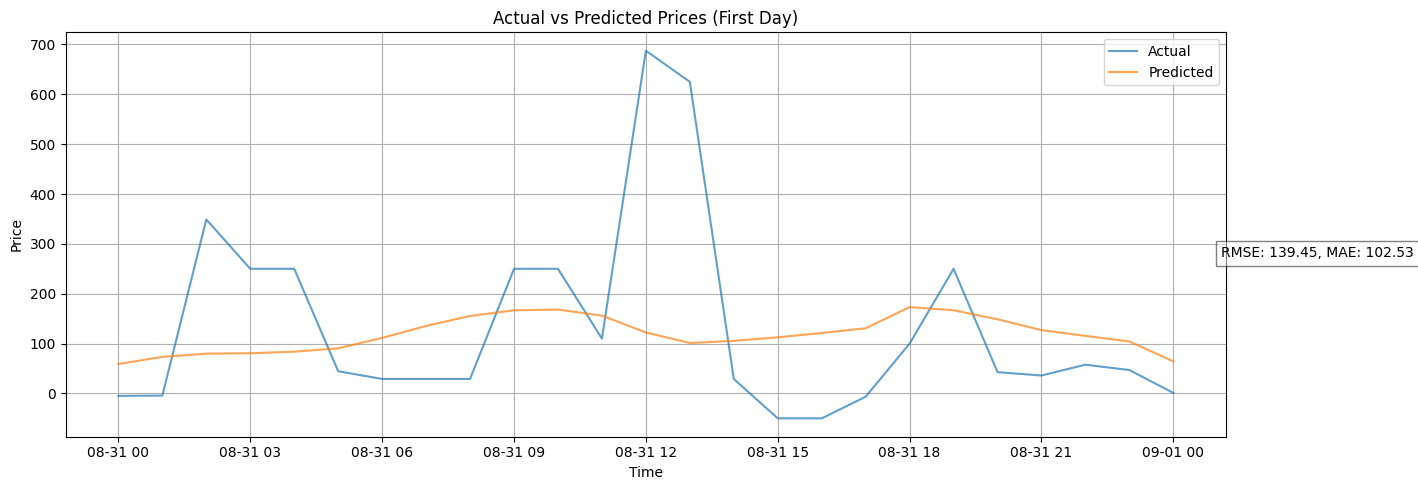

XGBoost test RMSE: 139.45488262275111, XGBoost test MAE: 102.52999127098256


In [13]:
xgb_y_pred, xgb_rmse, xgb_mae = predict(XGB_model, y_test, y_train, first, last)
plot_all(y_test, xgb_y_pred, xgb_rmse, xgb_mae)

if show_train_metrics:
    train_rmse, train_mae = get_train_metrics(XGB_model, data_df) #Note that it takes time to execute this
    print(f'XGBoost train RMSE: {train_rmse}, XGBoost train MAE: {train_mae}')

print(f'XGBoost test RMSE: {xgb_rmse}, XGBoost test MAE: {xgb_mae}')

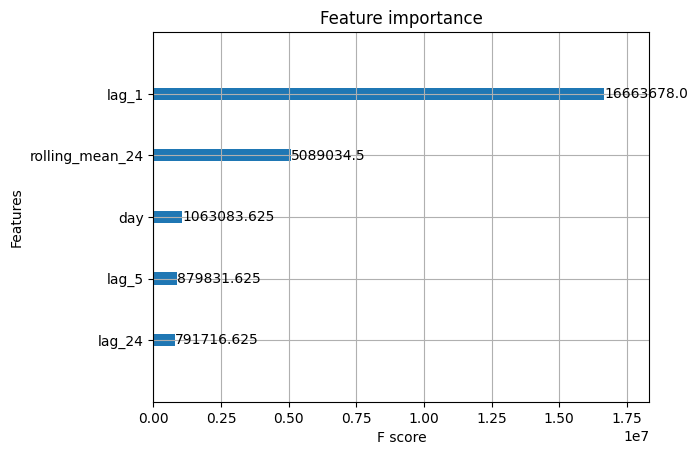

XGBoost Mean: 85.76, XGBoost Std: 55.90
Real Mean: 70.65, Real Std: 148.61


In [14]:
xgb.plot_importance(XGB_model, importance_type='gain', max_num_features=5) #show feature importance
plt.show()

xgb_mean = np.mean(xgb_y_pred)
xgb_std = np.std(xgb_y_pred)
y_test_mean = np.mean(y_test)
y_test_std = np.std(y_test)
print(f"XGBoost Mean: {xgb_mean:.2f}, XGBoost Std: {xgb_std:.2f}")
print(f"Real Mean: {y_test_mean:.2f}, Real Std: {y_test_std:.2f}")

We see that the most important feature for next hour prediction is the previous hour, which is reasonable. Rolling_mean_24 shows the overall price in the past 24 hours, which shows what the average price is in the previous 24 hours, which also makes sense. Month being third can indicate that there are some seasonal trends for the price.

XGB doesnt seem to perform better than linear regression. It also has slight overfitting. I played around with XGB parameters, and these above are the ones that minimize RMSE, other parameters had 145, 150, ... RMSE. I also added features (up in the code) to try to tell the model about the volatility of the data - I added the price change, the rolling standard deviation, the rolling range but unfortunately they didn't seem to help. I also tried the Scaler to normalize the features(subtract mean, divide by std), but again, doesn't seem to do anything. I tried using absolute error as objective to XGB instead of squared error, but the model became worse.

Lets now build an LSTM. We will convert the data to pytorch tensors, and scale it for the lstm to be between -1 and 1.

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim

# define the LSTM model in pytorch
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size=50, output_size=1, dropout_prob=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)

        self.dropout = nn.Dropout(dropout_prob)

        self.linear = nn.Linear(hidden_layer_size, output_size) #squeeze the last hidden vector into a single value - the prediction

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq) #this is a vector of the outputs of every lstm block

        # we only care about the output from the last time step for a single step prediction, so we take index -1
        # We use sequence length of 1(defined in next cell), so indexing by -1 will return the predicted price at every timestamp in the dataset.
        predictions = self.linear(self.dropout(lstm_out[:, -1, :]))

        return predictions

# Define model parameters
input_size = X_train.shape[1] #feature size
hidden_layer_size = 60 #information between lstm blocks size
output_size = 1 #we predict a single number - price
dropout_prob = 0.3 #regularization
learning_rate = 0.001

lstm_model = LSTMModel(input_size, hidden_layer_size, output_size, dropout_prob)
loss_function = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate)

print(lstm_model)

LSTMModel(
  (lstm): LSTM(36, 60, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear): Linear(in_features=60, out_features=1, bias=True)
)


In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1)) #transform the data between -1 and 1 because lstms are sensitive to scale of data and activation functions like sigmoid and tanh work better with this scaler
X_train_lstm = scaler.fit_transform(X_train_orig.copy())

# Convert data to pytorch tensors of size required by lstm - [samples, time steps, features]
X_train_lstm = torch.tensor(X_train_lstm.reshape(X_train_lstm.shape[0], 1, X_train_lstm.shape[1]), dtype=torch.float32)

# convert pd series to numpy 2d array
y_train_lstm = y_train.values.reshape(-1, 1)

#Scale the target variable between [-1;1]
y_scaler = MinMaxScaler(feature_range=(-1, 1))
y_train_lstm = torch.tensor(y_scaler.fit_transform(y_train_lstm), dtype=torch.float32)


#train lstm
epochs = 70

for i in range(epochs): #trains fast enough to not need gpu
    lstm_model.train()
    optimizer.zero_grad()

    y_pred_lstm = lstm_model(X_train_lstm) #predict on scaled data, produce scaled data
    loss = loss_function(y_pred_lstm, y_train_lstm) #calculate loss on scaled data

    loss.backward()
    optimizer.step()

    if i % 10 == 0:
        print(f'Epoch {i} loss {loss.item():.3f}')


print(f'Final Loss: {loss.item():.3f}')

Epoch 0 loss 0.498
Epoch 10 loss 0.163
Epoch 20 loss 0.012
Epoch 30 loss 0.029
Epoch 40 loss 0.011
Epoch 50 loss 0.013
Epoch 60 loss 0.011
Final Loss: 0.011


In [17]:
#similarly to the way we did this with the other models, we will feed the lstm one step at a time because we need it to make 24 predictions at once, not using the ground truth data at every hour

#Notice that unscaled data is passed to this function, scaling is performed internally
def predict_lstm(model, y_test, y_train, first, last, scaler, y_scaler): #y_test is used only to calculate RMSE and MAE metrics at the end
    history_data = y_train.copy()
    assert(len(history_data) > 72)

    forecast_results = [] # will keep all predicted results from the whole test dataset

    current_time = first

    model.eval()

    with torch.no_grad(): # disable gradient calculation because we are currently testing
        while current_time <= last:
            row = build_row(history_data, current_time)
            row = row if isinstance(row, np.ndarray) else row.to_numpy() # This will be a pd dataframe if no scaler was previously used and a numpy array if scaler was used

            row_scaled = scaler.transform(row)
            row_tensor = torch.tensor(row_scaled.reshape(1, 1, row_scaled.shape[1]), dtype=torch.float32) #[1 sample, 1 time step, row_scaled.shape[1] features]

            pred_scaled = model(row_tensor).numpy()

            pred = y_scaler.inverse_transform(pred_scaled)[0][0] # inverse transform expects 2D array, result is 2D, take first element since we are doing this a single step at a time and array size is 1

            forecast_results.append((current_time, pred))

            new_row = pd.DataFrame({'price': [pred]}, index=[current_time])
            history_data = pd.concat([history_data, new_row])

            # every 24 hours replace predictions in history_data with ground truth
            if len(forecast_results) > 0 and len(forecast_results) % 24 == 0:
                last_24_timestamps = [ts for ts, _ in forecast_results[-24:]]
                true_vals = y_test.loc[last_24_timestamps]
                true_df = pd.DataFrame({'price': true_vals})
                history_data[-24:] = true_df


            current_time += pd.Timedelta(hours=1) # increment time with 1 hour


    forecast_df = pd.DataFrame(forecast_results, columns=['datetime', 'predicted_price']).set_index('datetime')

    rmse = np.sqrt(mean_squared_error(y_test, forecast_df['predicted_price']))
    mae = np.mean(np.abs(y_test - forecast_df['predicted_price']))

    return (forecast_df['predicted_price'], rmse, mae)

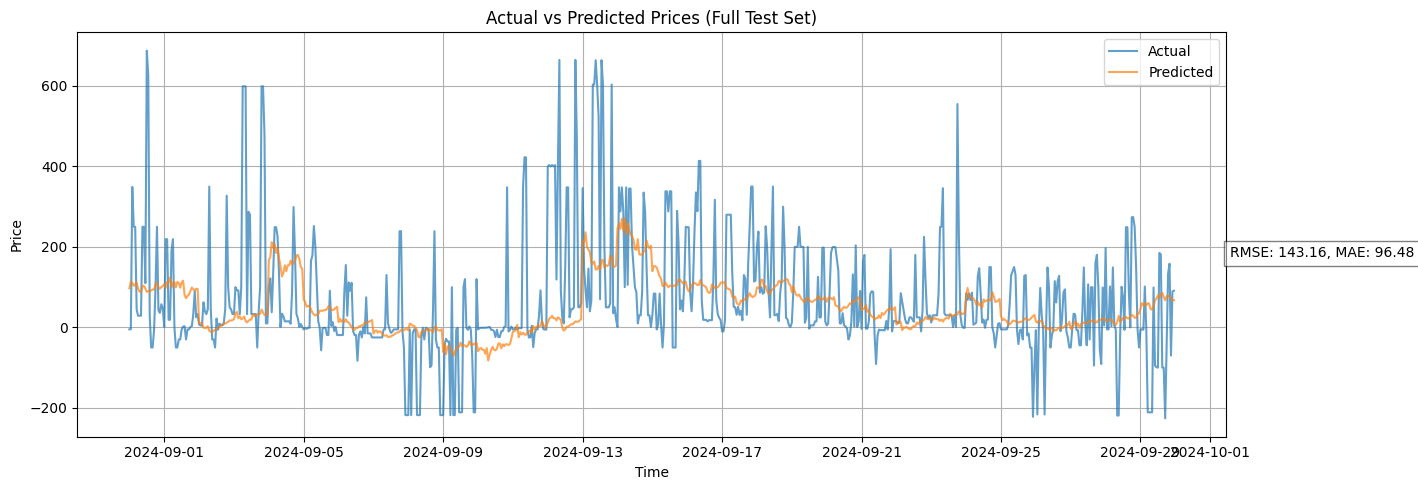

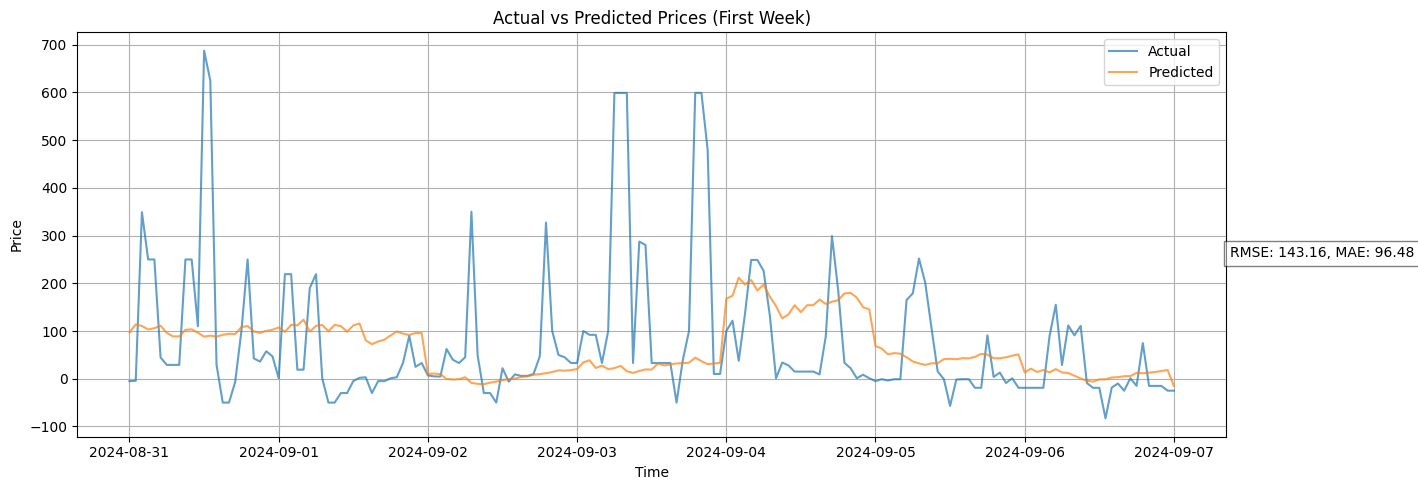

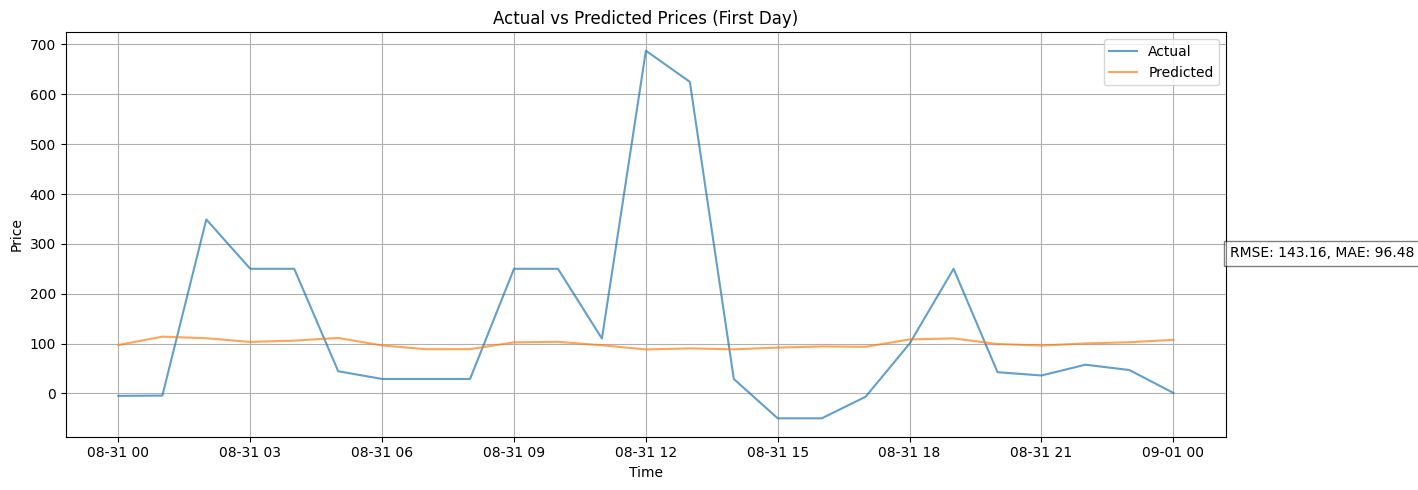

LSTM test RMSE: 143.15782500142421, LSTM test MAE: 96.47650642132096


In [18]:
if show_train_metrics:
    train_rmse, train_mae = get_train_metrics(lstm_model, data_df, lstm=True, scaler=scaler, y_scaler=y_scaler) #Note that it takes time to execute this
    print(f'LSTM train RMSE: {train_rmse}, LSTM train MAE: {train_mae}')

lstm_y_pred, lstm_rmse, lstm_mae = predict_lstm(lstm_model, y_test, y_train, first, last, scaler, y_scaler)
plot_all(y_test, lstm_y_pred, lstm_rmse, lstm_mae)
print(f'LSTM test RMSE: {lstm_rmse}, LSTM test MAE: {lstm_mae}')

I played around with the hyperparameters of the LSTM model but there isn't much of an improvement. Overall, all models performed similarly for this task, with XGBoost being slightly better than the others. Adding features to the data to introduce metrics for volatility doesn't seem to help, models don't learn from it - 6hr range, rolling std, price change, the resulting std from the predictions is still lower than the real std.
I presume making a model for this data is not an easy task, since it is very volatile and unpredictable. Maybe using external data - e.g. weather, demand, market prices - will improve the results.

Since we trained a couple of different models, we could try a tactic called stacking to combine their predictions - train a "meta-model" which is trained ot learn how to combine results of different models - predictions of different models are used as features for the meta model. The problem is that it is computationally heavy.



---


To quantify uncertainty for our models, we can calculate confidence intervals for each of our predictions that give the interval, for which the prediction will be in x% of the time. A universal algorithm to do that is bootstrapping and it works for every model. The idea behind bootstrapping is to resample multiple times our dataset(with repetition) such that we simulate the process of getting many datasets - for example resample 1000 times. For each of the bootstrapped datasets we can train a model and make the prediction using this model. Using these predictions from the different models we can approximate the probability distribution of the prediction. Using this distribution, we can build the confidence interval. This is a sort of Monte Carlo method that resamples the dataset.

The problem with bootstrapping is training all these models. This is slow and computationally expensive, especially for our neural network LSTM, whose training is slower.

We can use statsmodels.OLS to get confidence interval for our linear regression model. Statsmodels offers analytical confidence intervals for both the mean prediction and individual forecasts. We are interested in the latter.

In [19]:
#I think there are two ways to computing confidence intervals. First one is confidence interval of prediction at hour X, given hour X-1 - meaning we take hour X-1 as ground truth and compute the confidence interval of hour X. This can be implemented like this:

#I. First way to compute confidence intervals

#We can write another predict function that is compatible with sm.OLS, the only difference with the current function will be the interface to using the model - we would pass sm.OLS instead of sklearn.linear_model LinearRegression.
# In the created forecast_df at the end of the function, we can also return a forecast_df['ci_lower'] and forecast_df['ci_upper'] columns as well.
#We would also need to create X_new(see code below) on every iteration using the predicted info until this point(the history_data in predict function) and update the predictions with ground truth every 24 hours(like we do in the original implementation of predict function).
#I didn't do this, because I didn't want to increase the complexity of the predict function above,
#and I wanted to focus on demonstrating the logic with using a vanilla LinearRegression. Confidence intervals are a bonus feature that can be implemented.

#II. Second way to compute confidence intervals

#The second way is to calculate confidence interval of prediction at hour X without considering hour X-1 prediction as ground truth. We should note that confidence intervals in this case compound over time in our 24 hour autoregressive model, and I think
#they will increase a lot by the end of the day.
#To do it correctly, we could do bootstrapping monte carlo simulations, meaning we sample the distribution at step 1(the same distribution I explained above this cell when talking about bootstraping) and take this as hour 1 prediction,  use this
#sample as input to the next step, and repeat many times. At the end we can collect the predictions for each hour across all simulations and calculate confidence intervals.

#III. How to calculate confidence untervals using statsmodels.OLS
#Here, we aren't predicting the next 24 hours like we did above. This uses all ground truth information before the current hour for every hour prediction. The point of the code below is to demonstrate the idea.

import statsmodels.api as sm

X = X_train_orig.to_numpy()
y = y_train.to_numpy()

# Add constant for intercept, this is the y-intercept constant in the equation of a line. If we don't add it, we force the line to pass through origin, which is not necessarily the best solution. sklearn adds this by default.
X_sm = sm.add_constant(X)

model = sm.OLS(y, X_sm).fit()

X_new = X_test_orig.to_numpy()

# Add intercept to the test features as well
X_new_sm = sm.add_constant(X_new, has_constant='add')

pred = model.get_prediction(X_new_sm)

summary = pred.summary_frame(alpha=0.05)  # 95% CI

# Extract confidence intervals for all individual forecasts
prediction_ci_df = pd.DataFrame({
    'ci_lower': summary['mean_ci_lower'].to_numpy(),
    'ci_upper': summary['mean_ci_upper'].to_numpy()
}, index=X_test_orig.index)

display(prediction_ci_df.head()) #show first 5 CI's

,ci_lower,ci_upper
datetime,,
2024-08-31 00:00:00,24.191030,37.199250
2024-08-31 01:00:00,19.018679,31.283185
2024-08-31 02:00:00,10.358655,22.718693
2024-08-31 03:00:00,224.810093,238.604158
2024-08-31 04:00:00,186.704474,200.514411


Since XGBoost is a machine learning model(and not a statistical model like linear regression), there is no parametric form, so we can’t derive confidence intervals analytically like we did using sm.OLS for linear regression. This means we must estimate the confidence intervals empirically, using bootstrapping or quantile regression. Quantile regression is preferred, I already explained the downsides of bootstrapping. For quantile regression, we would need to train two XGB models:

```
model_lower = XGBRegressor(objective='reg:quantile', alpha=0.05)
model_upper = XGBRegressor(objective='reg:quantile', alpha=0.95)
```

These models predict prices for which there is 0.05 and 0.95 probability for the real price to fall under. This means if model_lower predicts X, then it is expected only 5% of real values fall below X. Then for a prediction at a given hour, we can take model_lower and model_upper's predictions, lets say a and b, and say that there is a 90% probability that the real value will be in the interval (a,b).

Now, to calculate confidence intervals for our LSTM model, we can again use bootstrapping or quantile regression. Since we have a multilayer perceptron, however, we can do this more easily by exploiting dropout and monte carlo simulations. Normally, dropout is only used in training, to increase regularization and prevent overfitting. Here, we can use dropout during inference. The idea is to run the same input, but each time use different random dropouts to deactivate some neurons. This will generate different outputs. Using these different outputs, we can again create a probability distribution of the predictions, from which we can derive confidence intervals.
This is some pseudocode how it can be computed:


```
#Pseudocode
predictions = []
for _ in range(100):
    y_pred = model(X_new, training=True)  # this keeps dropout on
    predictions.append(y_pred)

predictions = np.array(predictions)
lower = np.percentile(predictions, 5, axis=0)
upper = np.percentile(predictions, 95, axis=0)
#now use upper/lower to calculate 90% confidence interval like we did above
```




---

We can use external data, like weather, demand, market prices to make our model better. The idea is that if we have more features, then the model can associate these different features with price movements, and then make better predictions. The idea is simple, we need to find data (e.g. weather, demand, market prices), fetch it using API or upload CSV. We need to process the data such that we can use it(like we did with the original data), align it with hourly timestamps and join the data on our current dataframe. We should also probably do some feature engineering on the new data. After that, the code is the same. We basically just added additional columns to the data that provide more info. The difference will be in the add_features() and build_row() functions.



---


Example usage of the models in production:

1. At the start of every month:
 - Automatically update training set with new data - Replace manual CSV upload with scheduled API call; Data pipeline for processing data(call prepare_data() and add_features())
 - Rerun training.
 - If performance is acceptable, replace current model and save it to the cloud.

(\*): Cloud services can be used - store raw data in S3, use Glue to process and save data in another S3, train and deploy using SageMaker.
(**): Retraining is done in case of data changes with time and/or seasonality


2. Daily predictions - Make a workflow that:
 - Fetches the relevant data from the data pipeline needed for inference - feature building
 - Loads the trained model from cloud
 - Produces 24 hour predictions and writes them to cloud database/API endpoint


3. Using it in an application:
 -  Using (for example) FastAPI backend, have an API endpoint that uses model and returns results to client.
 - Deploy using docker + kubernetes
 - Use a dashboard to visualize predictions



4. Monitoring - using Grafana:
 - Compute predictions vs actuals each day - RMSE, MAE.
 - Log data quality issues, outliers - for example time zone changes, 2024 new years boom, ...
 - Alert on anomalies/high errors for human review
